<a href="https://colab.research.google.com/github/mbakos95/ICU-EDA-with-MIMIC-IV/blob/main/Zampakos_Christos_0096_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  AIDL03 Final Project - ICU EDA with MIMIC-IV
**Student:** Christos Zampakos  
**Student ID:** 0096  

# STEP 1: SETUP & IMPORTS

Importing the core libraries used throughout the analysis

pandas: For data manipulation and analysis

numpy: For numerical computations

matplotlib & seaborn: For creating plots and visualizations


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas and seaborn display options for cleaner outputs
pd.set_option('display.max_columns', 100)
sns.set(style="whitegrid")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/AIDL MASTER/AIDL_03/AIDL03 NICOLAOU/'

Mounted at /content/drive


#  STEP 3: READ DATASET FILES

In [ ]:
# Define a helper function to load CSVs efficiently
# We load only the first 100,000 rows to avoid memory overload, since some files are multiple GBs in size

def read_csv_efficient(path, usecols=None, nrows=100000):
    """
    Reads a large CSV file using pandas with optional row and column filters.
    Parameters:
        path (str): Full path to the CSV file
        usecols (list): Specific columns to load
        nrows (int): Number of rows to load (default: 100,000)
    Returns:
        DataFrame
    """
    return pd.read_csv(path, usecols=usecols, nrows=nrows)

# Load core MIMIC-IV tables for this analysis
patients = read_csv_efficient(data_path + 'patients.csv')
admissions = read_csv_efficient(data_path + 'admissions.csv')
icustays = read_csv_efficient(data_path + 'icustays.csv')
diagnoses = read_csv_efficient(data_path + 'diagnoses_icd.csv')
diag_lookup = read_csv_efficient(data_path + 'd_icd_diagnoses.csv')
prescriptions = read_csv_efficient(data_path + 'prescriptions.csv')
drgcodes = read_csv_efficient(data_path + 'drgcodes.csv')

/tmp/ipython-input-3-12010803.py:14: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, usecols=usecols, nrows=nrows)


# STEP 4: MERGE TABLES

In [ ]:
# Merge patient demographics, hospital admissions, ICU stays, diagnoses and descriptions
# Rationale: this combined view enables analysis on diagnoses and outcomes

# Merge patients with admissions
df1 = pd.merge(admissions, patients, on='subject_id', how='left')

# Add ICU stay data
df2 = pd.merge(df1, icustays, on=['subject_id', 'hadm_id'], how='left')

# Add diagnosis codes per admission
df3 = pd.merge(df2, diagnoses, on=['subject_id', 'hadm_id'], how='left')

# Add ICD descriptions
df_final = pd.merge(df3, diag_lookup, on='icd_code', how='left')

# STEP 5: CLEANING & FEATURE ENGINEERING

In [ ]:
# Drop any rows that don't have essential fields
# Reason: rows without these fields cannot be used for analysis or joins

# Copy for safe editing
df_cleaned = df_final.dropna(subset=['subject_id', 'hadm_id', 'icd_code', 'long_title']).copy()

# Convert timestamps and calculate Length of Stay (LOS)
df_cleaned['admittime'] = pd.to_datetime(df_cleaned['admittime'], errors='coerce')
df_cleaned['dischtime'] = pd.to_datetime(df_cleaned['dischtime'], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=['admittime', 'dischtime'])
df_cleaned['length_of_stay'] = (df_cleaned['dischtime'] - df_cleaned['admittime']).dt.days

# STEP 6: Q1 - Top Diagnoses

/tmp/ipython-input-7-579324920.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


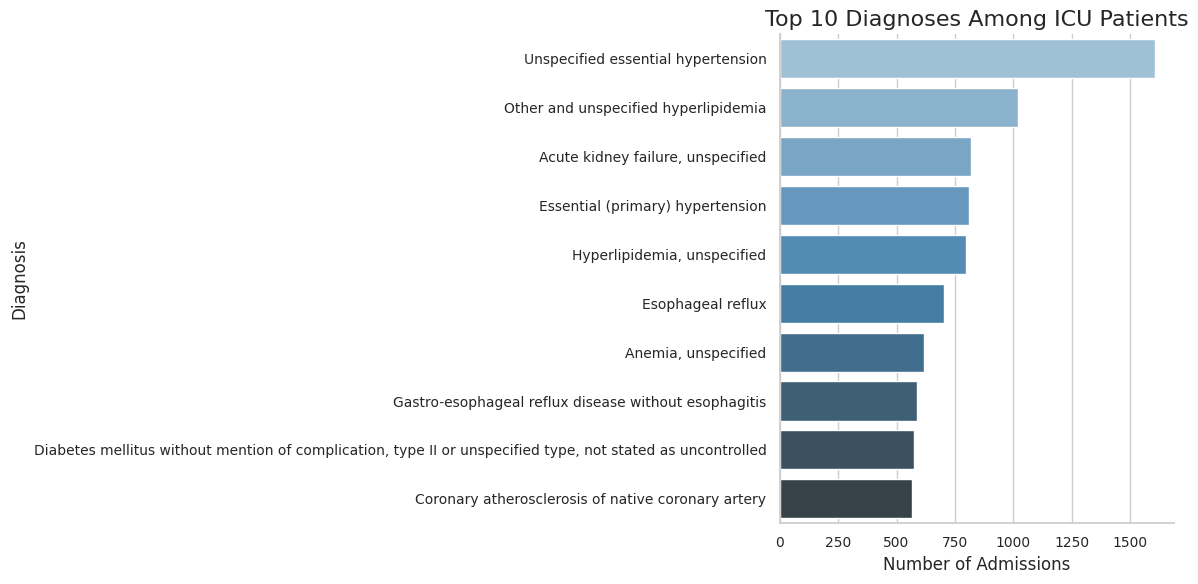

In [ ]:
# Get top 10 most frequent diagnoses
top_diagnoses = df_cleaned['long_title'].value_counts().head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    y=top_diagnoses.index,
    x=top_diagnoses.values,
    palette='Blues_d'
)

# Title and axis formatting
plt.title("Top 10 Diagnoses Among ICU Patients", fontsize=16)
plt.xlabel("Number of Admissions", fontsize=12)
plt.ylabel("Diagnosis", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Remove spines and tighten layout
sns.despine()
plt.tight_layout()
plt.show()
'''I used AI to apply the "Blues_d" color palette to this plot.
I asked ChatGPT the following:
"Can you give me 4 ideas on how to make this plot look better and more readable"
Also i have trouble with the text the one letter is on the other how can i fix that? '''


#STEP 7: Q2 - Prescription Patterns

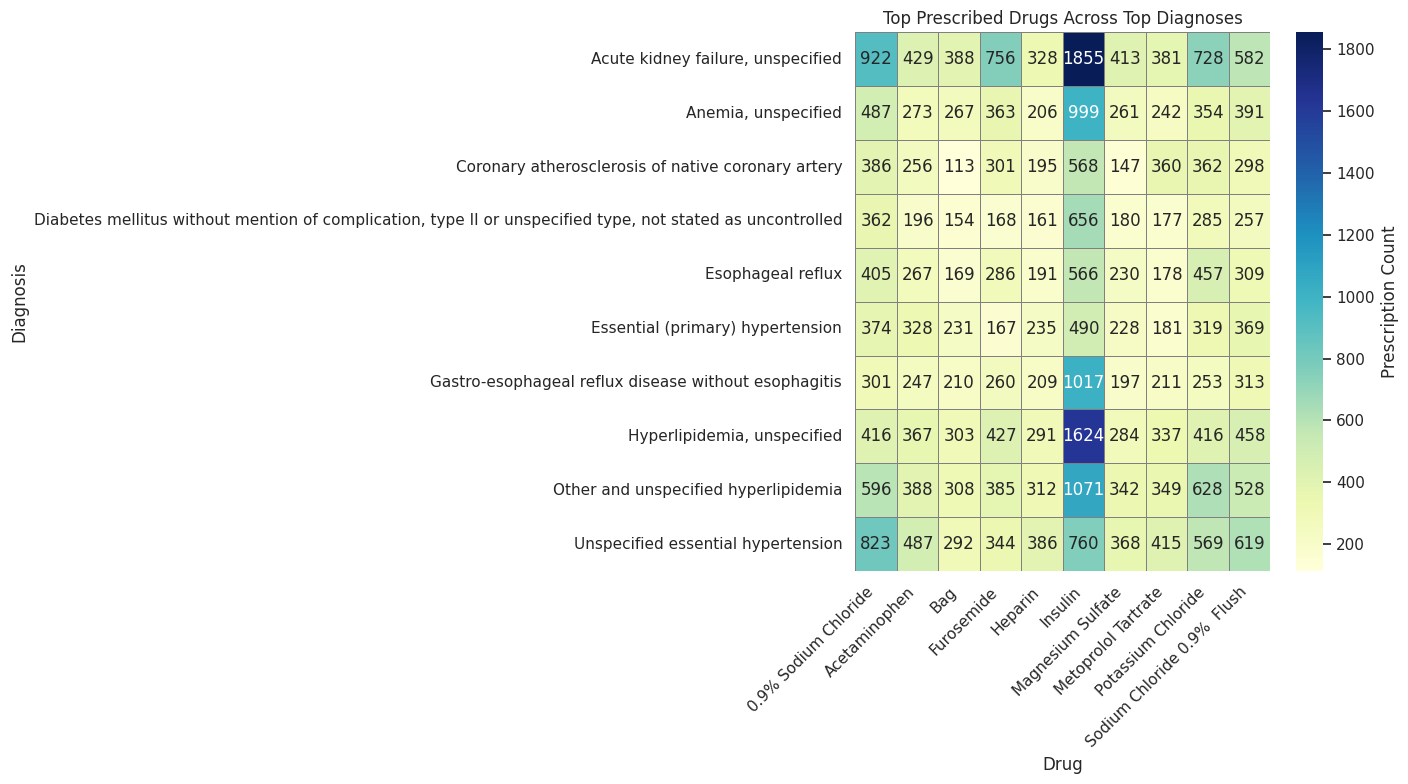

In [ ]:
# Merge with prescription data to analyze medications
prescriptions = prescriptions.dropna(subset=['hadm_id', 'drug'])
df_presc = pd.merge(df_cleaned, prescriptions, on='hadm_id', how='inner')

# Filter to top diagnoses
top_diag_names = df_cleaned['long_title'].value_counts().head(10).index.tolist()
df_presc_top = df_presc[df_presc['long_title'].isin(top_diag_names)]

# Count drugs per diagnosis
drug_counts = df_presc_top.groupby(['long_title', 'drug']).size().reset_index(name='count')
top_drugs = drug_counts.groupby('drug')['count'].sum().sort_values(ascending=False).head(10).index.tolist()
drug_counts_top = drug_counts[drug_counts['drug'].isin(top_drugs)]

# Pivot for heatmap
heatmap_data = drug_counts_top.pivot(index='long_title', columns='drug', values='count').fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Prescription Count'})
plt.title("Top Prescribed Drugs Across Top Diagnoses")
plt.xlabel("Drug")
plt.ylabel("Diagnosis")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

'''I used AI just to help with some visual aspects of the plot like picking a suitable color palette ("YlGnBu") and tweaking things like
the figure size and text alignment to make it more readable. All of the data processing, merging, and analysis were done by me.'''

#STEP 8: Q3 - LOS by Diagnosis and DRG

/tmp/ipython-input-17-38026946.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


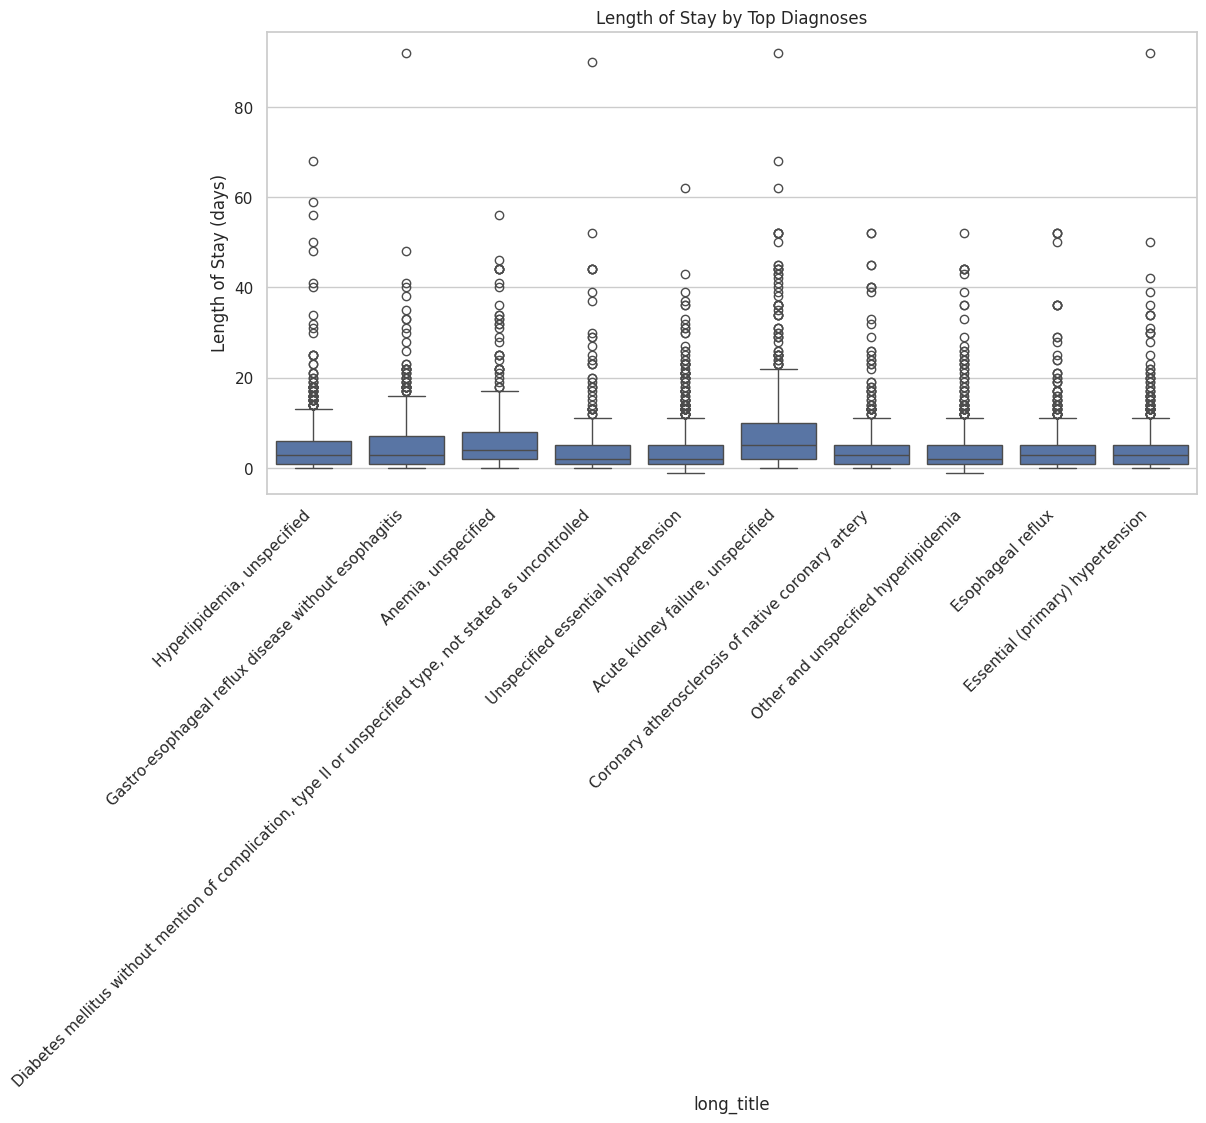

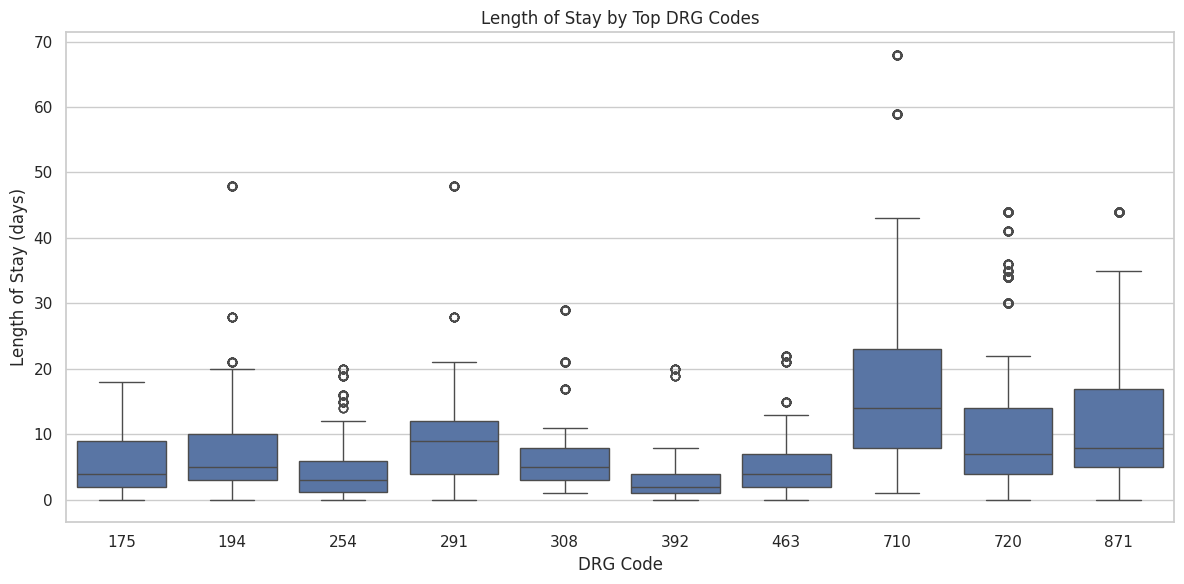

In [ ]:
# Boxplot: LOS by Diagnosis
df_top_los = df_cleaned[df_cleaned['long_title'].isin(top_diag_names)]
plt.figure(figsize=(12,6))
sns.boxplot(data=df_top_los, x='long_title', y='length_of_stay')
plt.title("Length of Stay by Top Diagnoses")
plt.ylabel("Length of Stay (days)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Boxplot: LOS by DRG
df_drg = pd.merge(df_cleaned, drgcodes[['subject_id', 'hadm_id', 'drg_code']], on=['subject_id', 'hadm_id'], how='inner')
top_drg = df_drg['drg_code'].value_counts().head(10).index.tolist()
df_drg_top = df_drg[df_drg['drg_code'].isin(top_drg)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_drg_top, x='drg_code', y='length_of_stay')
plt.title("Length of Stay by Top DRG Codes")
plt.xlabel("DRG Code")
plt.ylabel("Length of Stay (days)")
plt.tight_layout()
plt.show()

# STEP 9: Statistical Summary

In [ ]:
# LOS stats by Diagnosis
los_by_diag = df_top_los.groupby('long_title')['length_of_stay'].agg(['count', 'mean', 'median', 'std']).sort_values(by='count', ascending=False)
display(los_by_diag)

# LOS stats by DRG
los_by_drg = df_drg_top.groupby('drg_code')['length_of_stay'].agg(['count', 'mean', 'median', 'std']).sort_values(by='count', ascending=False)
display(los_by_drg)

,count,mean,median,std
long_title,,,,
Unspecified essential hypertension,1606,3.689290,2.0,5.084945
Other and unspecified hyperlipidemia,1019,4.043180,2.0,5.668832
"Acute kidney failure, unspecified",818,8.212714,5.0,9.776761
Essential (primary) hypertension,809,4.332509,3.0,6.465977
"Hyperlipidemia, unspecified",796,5.183417,3.0,6.785410
Esophageal reflux,703,4.322902,3.0,6.167614
"Anemia, unspecified",618,6.030744,4.0,7.576345
Gastro-esophageal reflux disease without esophagitis,586,5.537543,3.0,7.398045
"Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled",575,4.088696,2.0,7.201732


,count,mean,median,std
drg_code,,,,
720,2478,11.545601,7.0,11.797517
194,2069,6.903335,5.0,6.981000
871,2006,12.297607,8.0,11.995205
710,1167,17.537275,14.0,14.954423
291,1071,9.514472,9.0,8.272549
463,1003,5.037886,4.0,4.635901
392,1001,2.903097,2.0,2.964726
308,915,6.653552,5.0,6.135342
254,914,4.563457,3.0,4.661701


In [ ]:
'''I used AI here and I asked it to give me a list of the things I have done and to split them into two sections: Requirements and Implemented Steps.
I also asked it to evaluate my assignment based on the Evaluation Criteria that you provided us.  '''

## Assignment Checklist

|  | Requirement                                                                    | Implemented In STEPS                                        |
| -- | ------------------------------------------------------------------------------ | ------------------------------------------------------------- |
|   | Choose a dataset that interests you                                            | **STEP 2: Mount Google Drive** – MIMIC-IV                  |
|   | Formulate **at least 3 initial questions**                                     | **STEP 3: Read Dataset Files** (defined in Markdown intro) |
|  | Ensure the questions address **distinct, diverse aspects**                     | Q1: Diagnoses, Q2: Prescriptions, Q3: LOS by DRG/Diagnosis    |
|   | Perform **data quality assessment** (format, missing values, structure)        | **STEP 5: Cleaning & Feature Engineering**                 |
|   | Use **non-graphical methods** (statistical summaries, `.agg()`, `.describe()`) | **STEP 9: Statistical Summary**                            |
|   | Create **visualizations** to support each question                             | **STEP 6–8**: barplot, heatmap, boxplots                  |
|   | **Refine visualizations** with titles, axes, scales, rotations                 | All visualization steps use seaborn with `.tight_layout()` |
|   | Explore **follow-up questions** if needed                                      | Prescription pattern filtering in STEP 7                   |
|   | Well-documented notebook with **code + explanations**                          |  Throughout all steps with comments                       |
|   | Include **clear final summary / insights**                                     | **STEP 9: Statistical Summary** (can expand if needed)     |
|   | Deliverable is in **.ipynb** format                                            |  Generated notebook file                                     |
|   | Follow naming format: `Surname_Name_StudentNumber.ipynb`                       |  Mentioned in final instructions                             |


